# Procesamiento de Imágenes
## Trabajo Practico 5 - Segmentación de Imágenes

In [46]:
import cv2
from PIL import Image
import os   
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, filters
from skimage.data import human_mitosis

### 3. (*) Umbralización hı́brida (combinación de Otsu + morfologı́a). ¿Cómo mejorar la segmentación de objetos con ruido o regiones conectadas? Práctica sugerida: Aplicar Otsu, luego refinar con cv2.morphologyEx() (apertura o cierre).

Para evaluar esta técnica, se utilizó una imagen microscópica de mitosis humana, en la cual se observan múltiples núcleos celulares en diferentes fases del ciclo celular. Ahora hablaremos un poco de cada técnica morfológica usada:

**Otsu + Cierre:** Prácticamente no vemos diferencias a simple vista, pero se han rellenado pequeños huecos en el interior de algunos núcleos. Esto ayuda a representar de manera más sólida los núcleos que se encontraban fragmentados o con regiones de baja intensidad.

**Otsu + Apertura:** Podemos observar que se han eliminado pequeñas regiones blancas que probablemente corresponden a ruido o núcleos mal definidos. Además, el contorno de los núcleos es más limpio y continuo, lo que facilita un conteo más preciso.

**Otsu + Erosión:** Elimina muchas regiones pequeñas y separa algunos núcleos que estaban parcialmente conectados, pero también reduce el tamaño de los núcleos y puede hacer que pierdan parte de su estructura interna, lo cual podría afectar un análisis morfológico más detallado.

**Otsu + Dilatación:** Los núcleos se ven más grandes y los contornos están más cerrados. Esto permite unir fragmentos rotos, pero también provoca que núcleos cercanos se fusionen, dificultando la separación entre células individuales.

Lo ideal es siempre hacer un análisis previo de la imagen para aplicar Otsu y luego el operador morfológico necesario según lo que necesitemos.

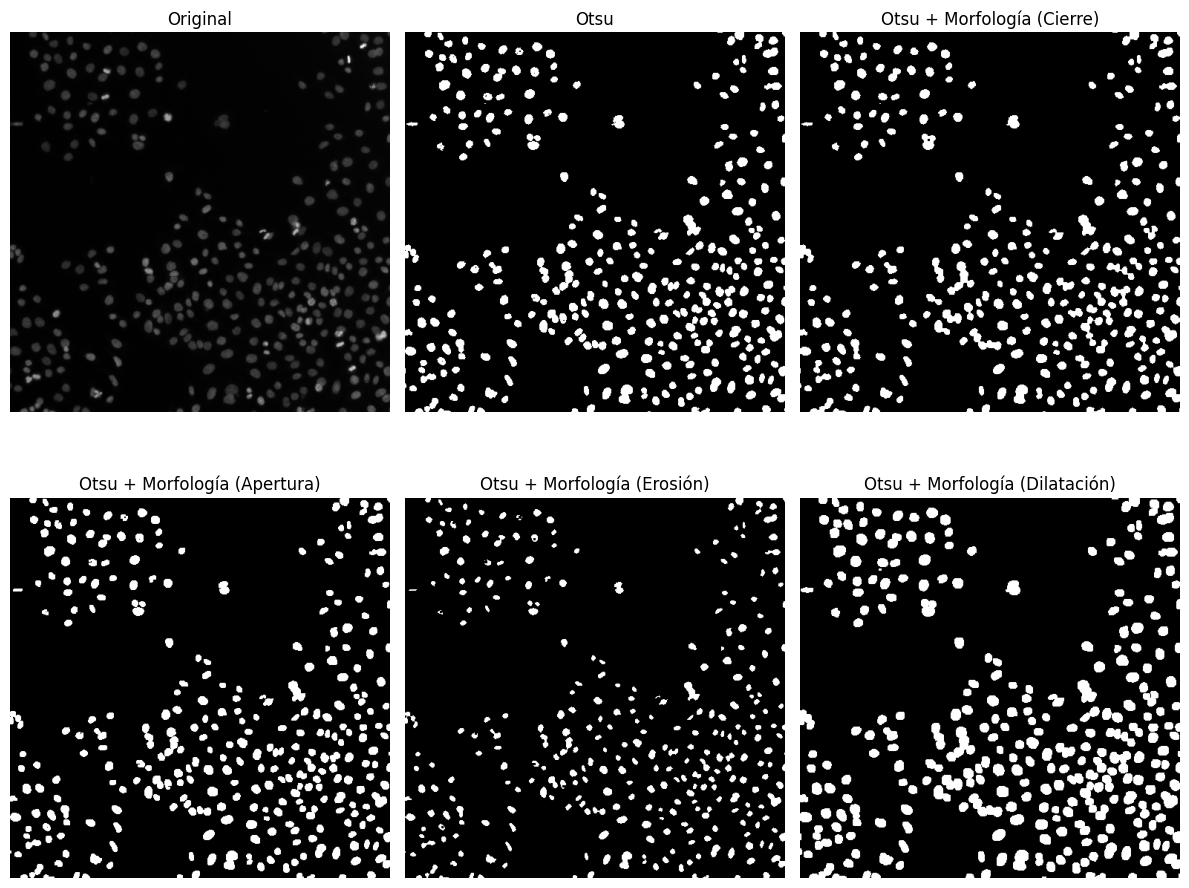

In [ ]:

# Load human mitosis image from skimage
render = human_mitosis()

# Apply Otsu
_, otsu_thresh = cv2.threshold(render, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Refine with Morphology
kernel = np.ones((3, 3), np.uint8)
refined_otsu_close = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel) 
refined_otsu_open = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel) 
refined_otsu_erode = cv2.morphologyEx(otsu_thresh, cv2.MORPH_ERODE, kernel)
refined_otsu_dilate = cv2.morphologyEx(otsu_thresh, cv2.MORPH_DILATE, kernel)

plt.figure(figsize=(12, 10))
plt.subplot(231), plt.imshow(render, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(232), plt.imshow(otsu_thresh, cmap='gray'), plt.title('Otsu'), plt.axis('off')
plt.subplot(233), plt.imshow(refined_otsu_close, cmap='gray'), plt.title('Otsu + Morfología (Cierre)'), plt.axis('off')

plt.subplot(234), plt.imshow(refined_otsu_open, cmap='gray'), plt.title('Otsu + Morfología (Apertura)'), plt.axis('off')
plt.subplot(235), plt.imshow(refined_otsu_erode, cmap='gray'), plt.title('Otsu + Morfología (Erosión)'), plt.axis('off')
plt.subplot(236), plt.imshow(refined_otsu_dilate, cmap='gray'), plt.title('Otsu + Morfología (Dilatación)'), plt.axis('off')
plt.tight_layout()
plt.show()


### 4. (*) Segmentación por detección de bordes. ¿Cómo se puede usar la información de bordes para segmentar una imagen? Práctica sugerida: Detectar bordes con cv2.Canny() o skimage.filters.sobel, luego aplicar umbral y cerrar regiones con morfologı́a.

En esta figura se comparan distintas variantes de segmentación por bordes usando los operadores Canny y Sobel, con y sin umbralización mediante Otsu, además del uso de morfología (cierre y dilatación) para reforzar regiones segmentadas.

Primero, observamos que los bordes extraídos con Canny generan una buena delimitación de los contornos del personaje, con líneas finas y bien definidas. El operador Sobel, por su parte, produce una imagen en escala de grises con bordes más difusos pero igualmente detectables.

Luego, se aplicó la umbralización automática de Otsu sobre los resultados de Canny y Sobel. Esta etapa permite aislar los bordes más destacables. En ambos casos, el resultado mejora la legibilidad de las estructuras, cerrando parte de los contornos y eliminando ruido de baja intensidad. La versión Otsu Sobel presenta bordes más gruesos y continuos, mientras que Otsu Canny conserva una mayor fidelidad en los detalles finos.

Finalmente, se aplicaron transformaciones morfológicas como el cierre y la dilatación a los resultados binarizados. El cierre ayudó a unir bordes fragmentados y rellenar huecos, generando figuras más sólidas y conectadas, aunque con pérdida de detalles internos. La dilatación, por su parte, expandió los contornos segmentados, haciendo que las regiones sean más visibles y compactas, pero también menos precisas en cuanto a la forma original.

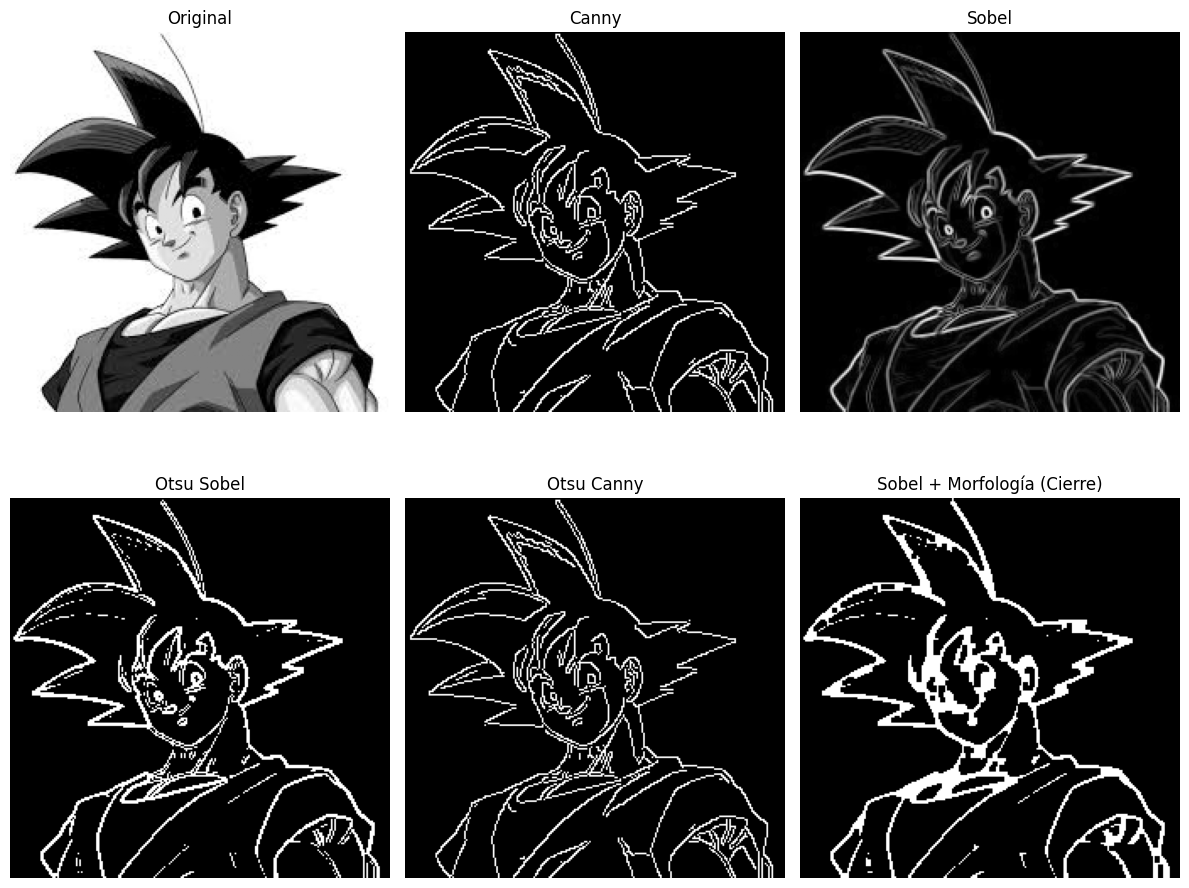

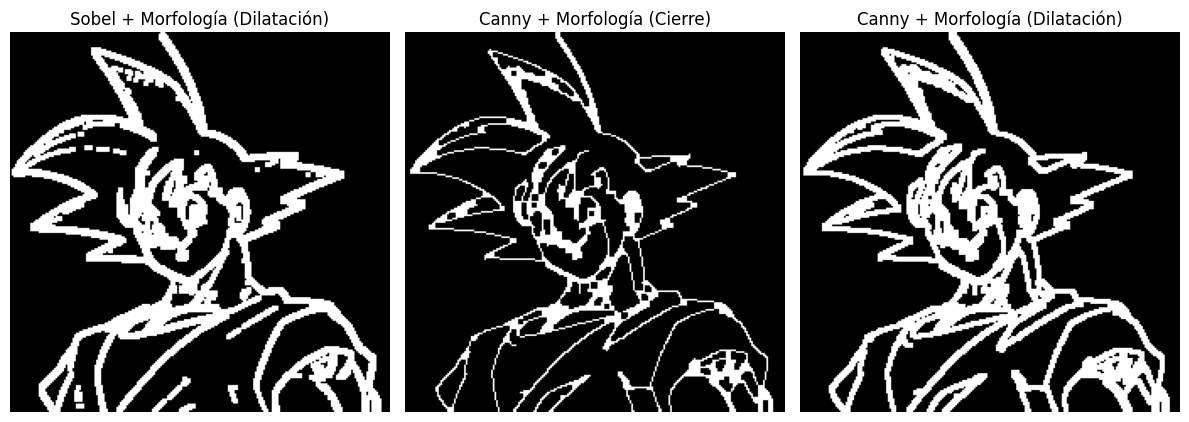

In [22]:
# Load render image

render = cv2.imread('./img/goku.jpeg', cv2.IMREAD_GRAYSCALE)

# Detection with Canny
edges_canny = cv2.Canny(render, 500, 150)

# Detection with Sobel
edges_sobel = filters.sobel(render)
edges_sobel = (edges_sobel * 255).astype(np.uint8)

# Apply Otsu on Sobel edges and canny edges
_, otsu_sobel = cv2.threshold(edges_sobel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, otsu_canny = cv2.threshold(edges_canny, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

## Apply close and dilate on Sobel and Canny edges
kernel = np.ones((3, 3), np.uint8)
refined_sobel_close = cv2.morphologyEx(otsu_sobel, cv2.MORPH_CLOSE, kernel)
refined_sobel_dilate = cv2.morphologyEx(otsu_sobel, cv2.MORPH_DILATE, kernel)
refined_canny_close = cv2.morphologyEx(otsu_canny, cv2.MORPH_CLOSE, kernel)
refined_canny_dilate = cv2.morphologyEx(otsu_canny, cv2.MORPH_DILATE, kernel)


# Plot original image and otsu
plt.figure(figsize=(12, 10))
plt.subplot(231), plt.imshow(render, cmap='gray'), plt.title('Original'), plt.axis('off')
plt.subplot(232), plt.imshow(edges_canny, cmap='gray'), plt.title('Canny'), plt.axis('off')
plt.subplot(233), plt.imshow(edges_sobel, cmap='gray'), plt.title('Sobel'), plt.axis('off')
plt.subplot(234), plt.imshow(otsu_sobel, cmap='gray'), plt.title('Otsu Sobel'), plt.axis('off')
plt.subplot(235), plt.imshow(otsu_canny, cmap='gray'), plt.title('Otsu Canny'), plt.axis('off')

# Plot sobel_close and dilate and canny_close and dilate
plt.subplot(236), plt.imshow(refined_sobel_close, cmap='gray'), plt.title('Sobel + Morfología (Cierre)'), plt.axis('off')
plt.tight_layout()
plt.figure(figsize=(12, 10))
plt.subplot(231), plt.imshow(refined_sobel_dilate, cmap='gray'), plt.title('Sobel + Morfología (Dilatación)'), plt.axis('off')
plt.subplot(232), plt.imshow(refined_canny_close, cmap='gray'), plt.title('Canny + Morfología (Cierre)'), plt.axis('off')
plt.subplot(233), plt.imshow(refined_canny_dilate, cmap='gray'), plt.title('Canny + Morfología (Dilatación)'), plt.axis('off')
plt.tight_layout()
plt.show()


### 8. (*) Segmentación basada en regiones (crecimiento o split-merge). ¿Cómo se puede segmentar una imagen expandiendo regiones homogéneas? Práctica sugerida: Usar skimage.segmentation.flood() o flood fill() para realizar crecimiento de regiones desde semillas.

La segmentación de una imagen mediante crecimiento de regiones, funciona iniciando desde un punto o conjunto de puntos denominados semillas. A partir de estas semillas, el algoritmo examina los píxeles vecinos y los agrega a la región si cumplen un criterio de homogeneidad predefinido, como una diferencia de intensidad similar dentro de una tolerancia específica. Este proceso se repite iterativamente, expandiendo la región hasta que no se encuentren más píxeles vecinos que satisfagan el criterio. Este proceso depende mucho de la semilla y tolerancia elegida, pero es muy útil para segmentar y definir regiones sin mucho ruido y bien delimitadas.



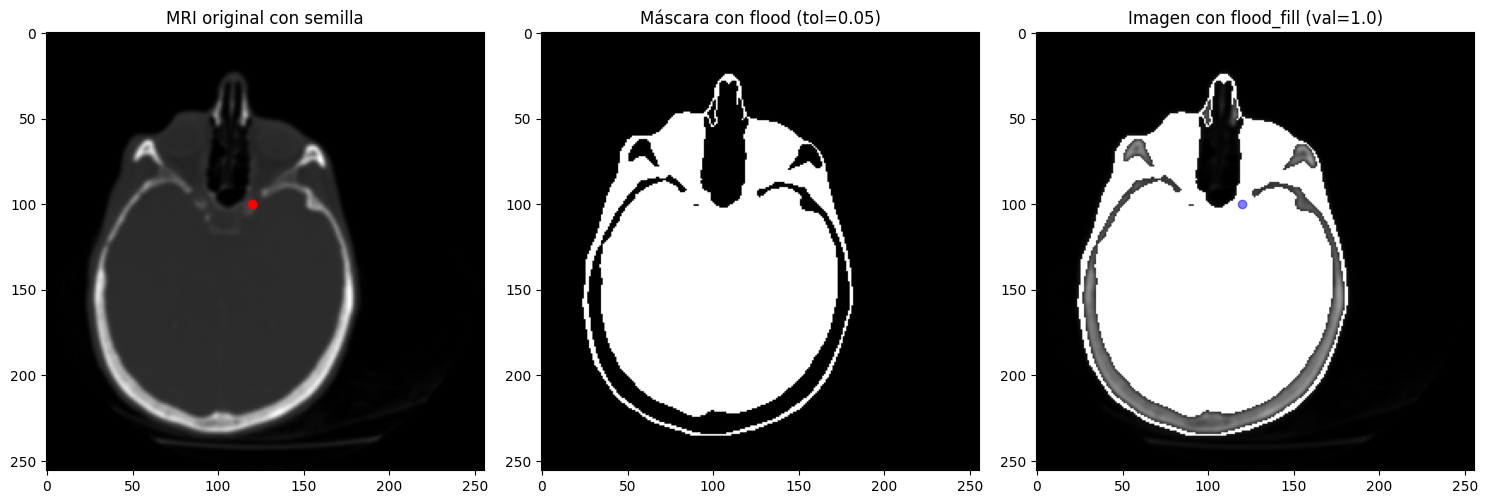

In [55]:


# Cargar imagen cerebral
image = data.brain()[9]

# Suavizado y semilla
image_smooth = filters.gaussian(image, sigma=1)
seed_point = (100, 120)
tolerance_value = 0.05 

# Crecimiento de región con segmentation.flood
mask = segmentation.flood(image_smooth, seed_point, tolerance=tolerance_value)

# Relleno de región con segmentation.flood_fill 
image_for_flood_fill = image_smooth.copy()

new_pixel_value = 1.0 

# Aplicar flood_fill
filled_image = segmentation.flood_fill(image_for_flood_fill,
                                       seed_point,
                                       new_value=new_pixel_value,
                                       tolerance=tolerance_value)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].imshow(image_smooth, cmap='gray')
axes[0].plot(seed_point[1], seed_point[0], 'ro')
axes[0].set_title('MRI original con semilla')


axes[1].imshow(mask, cmap='gray')
axes[1].set_title(f'Máscara con flood (tol={tolerance_value})')

axes[2].imshow(filled_image, cmap='gray')
axes[2].plot(seed_point[1], seed_point[0], 'bo', alpha=0.5) 
axes[2].set_title(f'Imagen con flood_fill (val={new_pixel_value})')

plt.tight_layout()
plt.show()

### 10. (*) Segmentación por combinación de técnicas (pipeline) Pregunta: ¿Qué beneficios tiene combinar varias técnicas de segmentación en un mismo flujo de procesamiento? Práctica sugerida: Aplicar primero Canny + morfologı́a para generar una máscara, luego segmentar con Watershed o K-means sobre la región recortada.

Combinar varias técnicas de segmentación en un pipeline permite aprovechar las fortalezas de cada método para obtener un resultado más preciso y robusto.

Por ejemplo, usar Canny detecta los bordes más relevantes de una imagen; aplicar operaciones morfológicas (como dilatación o cierre) mejora la conectividad y limpieza de esos bordes; luego, técnicas como K-means o Watershed pueden segmentar regiones internas con mayor coherencia, al trabajar solo sobre áreas importantes delimitadas por la máscara.

Esto reduce el procesamiento de zonas irrelevantes (como el fondo), evita errores de sobresegmentación y mejora la calidad visual y estructural del resultado final.

En resumen, un pipeline bien diseñado mejora la segmentación al combinar precisión local (bordes) con agrupación global (regiones o colores).

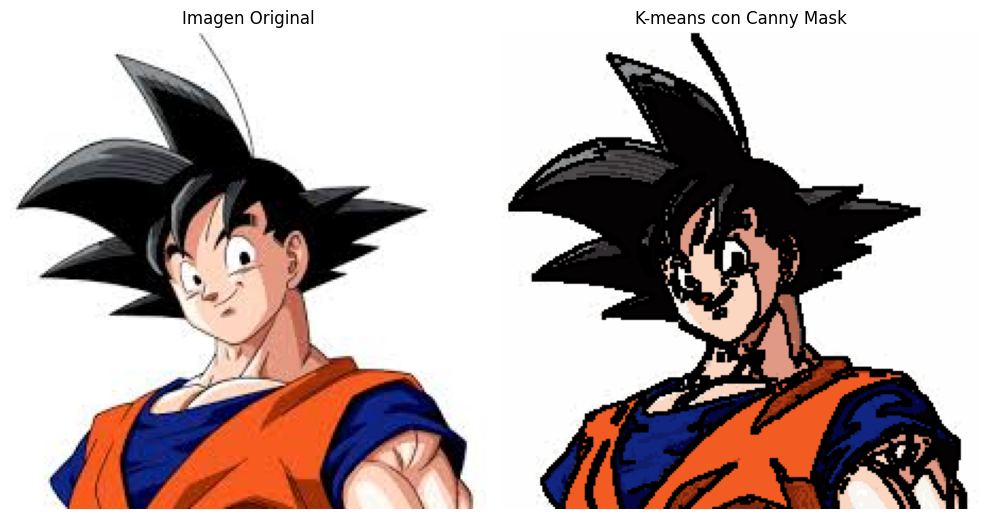

In [78]:
goku = cv2.imread('./img/goku.jpeg', cv2.IMREAD_GRAYSCALE)
goku_color = cv2.imread('./img/goku.jpeg')

# Apply canny edge detection
edges = cv2.Canny(goku, 100, 200)
# Apply morphology to refine edges
kernel = np.ones((2, 2), np.uint8)
refined_edges_dilate = cv2.morphologyEx(edges, cv2.MORPH_DILATE, kernel)

mask = cv2.bitwise_not(refined_edges_dilate)

Z = goku_color.reshape((-1, 3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 25
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((goku_color.shape))

# Aplicar la máscara para mostrar solo regiones detectadas por Canny
masked_kmeans = cv2.bitwise_and(res2, res2, mask=mask)

# Mostrar resultados
plt.figure(figsize=(10, 8))
plt.subplot(121), plt.imshow(cv2.cvtColor(goku_color,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Imagen Original'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(masked_kmeans,cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('K-means con Canny Mask'), plt.axis('off')
plt.tight_layout()
plt.show()



### 11. (*) Elegir y describir alguno de las siguientes tecnicas de segmentación:
    (a) Basada en Clustering
    (b) Basada en Grafos
    (c) Basadas en Modelos Probabilı́sticos y Estadı́sticas

#### Explicación de la Técnica

Para la segementación basada en grafos, se representa la imágen como un grafo fully no dirigído connected (lo cual tiene un alto coste computacional) en el cual cada pixel es un nodo y hay una arista por cada par de píxeles `p` y `q` (cada arista tienen un peso que mide la similitud entre píxeles). Se puede observar en la siguiente imagen:

![graph_image](./img/inform1.png)


La segmentación basada en grafos consiste en eliminar ciertas aristas del grafo para dividirlo en componentes. Las aristas con mayor peso son cnadidatas a corte ya que probablemente separan regiones distintas. Se puede observar en la siguiente imagen:

![graph_image](./img/inform2.png)

#### Diferentes algoritmos

Existen diferentes algoritmos para la segmentación basada en grafos:

**Normalized Cut**

Se basa en minimizar la relación entre el coste del corte y la suma de los pesos de las aristas dentro de cada segemento.

Divide recursivamente el grafo en subgrafos más pequeños hasta que se cumplen los criterios de parada.

**Minimum Cut**

Se basa en buscar el corte mínimo en el grafo (el corte con el menor peso).

El algoritmo parte el grafo en dos segmentos removiendo los bordes con pesos más pequeños hasta desconectarlo.

#### Ventajas y desventajas


| Factor      | Ventajas                                                                 | Desventajas                                                                 |
|-------------|--------------------------------------------------------------------------|------------------------------------------------------------------------------|
| Flexibilidad | Aplica a distintos tipos de imágenes y características (color, textura). | Requiere ajustar varios parámetros (pesos, criterios de partición).         |
| Precisión    | Capta detalles finos y contornos usando información local y global.      | Puede generar sobresegmentación si el grafo se divide incorrectamente.      |
| Eficiencia   | Algoritmos rápidos y aptos para imágenes grandes y tiempo real.          | Técnica compleja que exige muchos recursos y es difícil de implementar.     |


#### Bibliografía

Kak, A. (s/f). Graph-Based Techniques for Image Segmentation. Purdue.edu. Recuperado el 3 de junio de 2025, de https://engineering.purdue.edu/kak/Tutorials/GraphBased.pdf

(S/f-a). Princeton.edu. Recuperado el 3 de junio de 2025, de https://www.cs.princeton.edu/courses/archive/spr18/cos598B/slides/cos598b_7feb18_graphcut.pdf

(S/f-b). Baeldung.com. Recuperado el 3 de junio de 2025, de https://www.baeldung.com/cs/graph-based-segmentation
